## Tuning a KNN model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

def income_model_data_prep(data):
    data = pd.get_dummies(
        income.assign(
                target = np.where(data["SalStat"]==" less than or equal to 50,000", 0,1),
                nativecountry = data["nativecountry"].str.replace(" Holand-Netherlands",
                                                         " Germany"),
                JobType = data["JobType"].replace({" Never-worked":" Without-pay"}),
                occupation = data["occupation"].str.replace(" Armed-Forces"," ?")
                ).drop("SalStat",axis=1),
        drop_first=True
    )
    X = data.drop(columns=["target"],axis=1)
    y = data["target"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

    return X_train, X_test, y_train, y_test

In [3]:
income = pd.read_csv("../Data/income.csv")

X_train, X_test, y_train, y_test = income_model_data_prep(income)

In [9]:
X_train.shape

(25582, 94)

In [5]:
### Scale the model (Standardize)
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [8]:
X_train_std.shape

(25582, 94)

In [11]:
### Fit the model using KNN
from sklearn.neighbors import KNeighborsClassifier

k = 5

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_std,y_train)


KNeighborsClassifier()

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(f'Train accuracy: {accuracy_score(y_train, knn.predict(X_train_std))}')
print(f'Test accuracy: {accuracy_score(y_test, knn.predict(X_test_std))}')



Train accuracy: 0.8758892971620671
Test accuracy: 0.8239524702939337


In [20]:
### Tune the model using cross validation
from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": range(49,60)}

gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)

gridsearch.fit(X_train_std, y_train)

gridsearch.best_params_

{'n_neighbors': 57}

In [32]:
k = gridsearch.best_params_['n_neighbors']
# k = 25
knn = KNeighborsClassifier(k)

knn.fit(X_train_std, y_train)


KNeighborsClassifier(n_neighbors=57)

In [33]:
print(f'Train accuracy: {accuracy_score(y_train, knn.predict(X_train_std))}')
print(f'Test accuracy: {accuracy_score(y_test, knn.predict(X_test_std))}')

Train accuracy: 0.8341802830114925
Test accuracy: 0.8344277673545967


In [41]:
# from pprint import pprint
from sympy import Matrix, init_printing
init_printing()

matrix_confusion = Matrix(confusion_matrix(y_test, knn.predict(X_test_std)))

pprint(matrix_confusion)

Matrix([
[4512, 340],
[ 719, 825]])


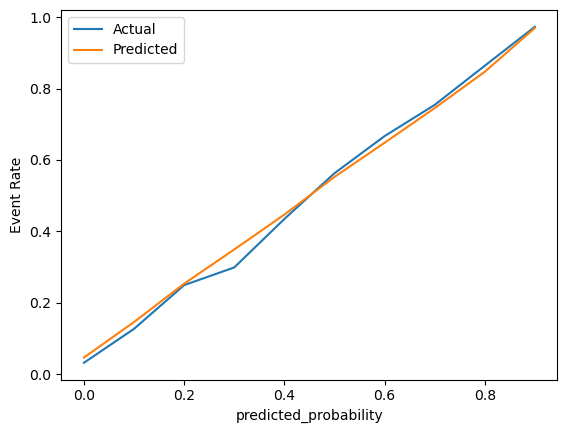

In [48]:
bins = np.linspace(0, 1, 11)

# Create dataframe with Actual Classes & Predicted Probabilities
actual_vs_prob = (
    pd.DataFrame({
        "Actual": y_test,
        "Predicted": knn.predict_proba(X_test_std)[:, 1]})
)

# Create bins at increments of .1
actual_vs_prob["predicted_probability"] = (
    pd.cut(actual_vs_prob["Predicted"], 
    bins=bins,
    labels = bins[:-1].round(2)
          )
)

# Group by probability bins and calculate actual even rate & plot
(actual_vs_prob
 .groupby("predicted_probability",observed=True)
 .agg({"Actual": "mean", "Predicted": "mean"})
 .plot
 .line(ylabel="Event Rate")
);

In [52]:
actual_vs_prob.groupby("predicted_probability",observed=True).agg({"Actual": "mean", "Predicted": "mean"})

,Actual,Predicted
predicted_probability,,
0.0,0.031827,0.046523
0.1,0.126932,0.146063
0.2,0.249315,0.253449
0.3,0.298851,0.349197
0.4,0.434599,0.446887
0.5,0.562674,0.552461
0.6,0.666667,0.648117
0.7,0.754167,0.745175
0.8,0.863850,0.846882
